In [1]:
!pip install pennylane-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.9/245.9 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [5]:
#imports
import pennylane as qml
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
import numpy as np


Get Expantion of a gate for given set of gates

In [6]:
# Define Circuit
circuit = QuantumCircuit(1)
circuit.ry(Parameter('theta'), 0)

# Get Expantion for given gates
rxrz_basis = transpile(circuit, basis_gates=['cx', 'id', 'rz', 'x', 'sx'])
rxrz_basis.draw()

global phase: 3π/2
   ┌────┐┌───────────────┐┌────┐┌────────┐
q: ┤ √X ├┤ Rz(theta + π) ├┤ √X ├┤ Rz(3π) ├
   └────┘└───────────────┘└────┘└────────┘

Custom Gate decomposition for pennylane circuit

(<Figure size 1700x500 with 1 Axes>, <Axes: >)
(<Figure size 3500x500 with 1 Axes>, <Axes: >)


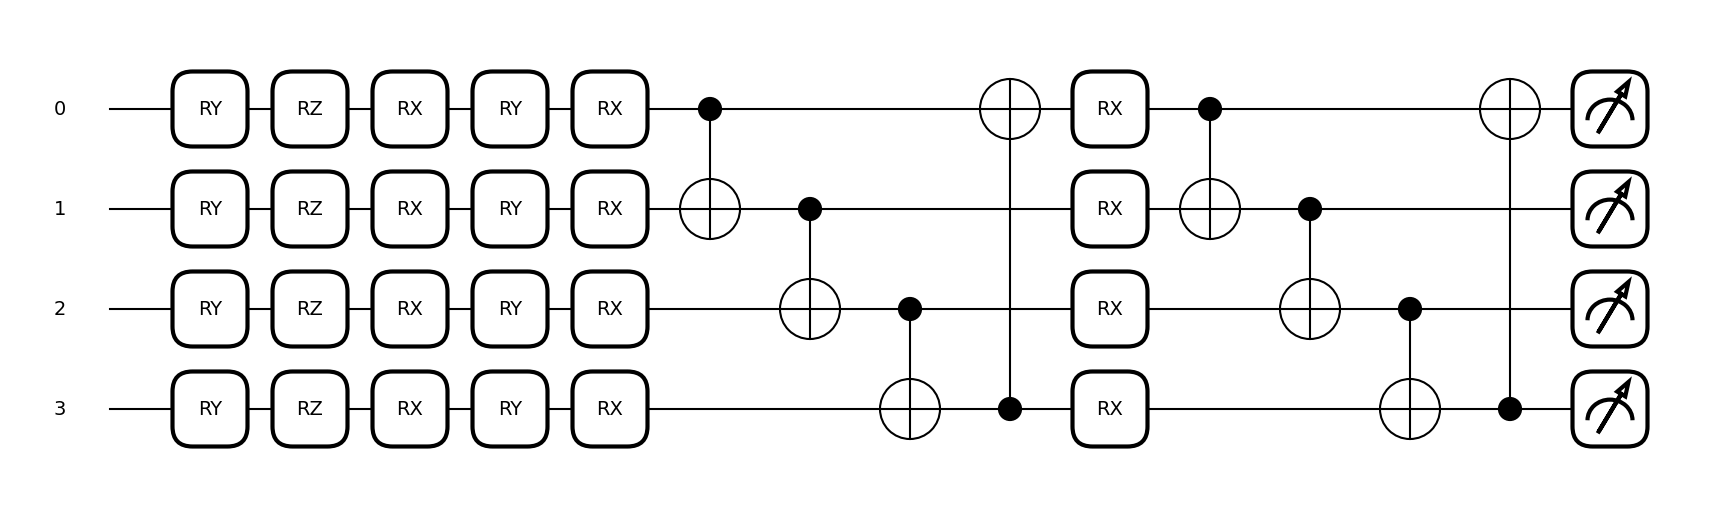

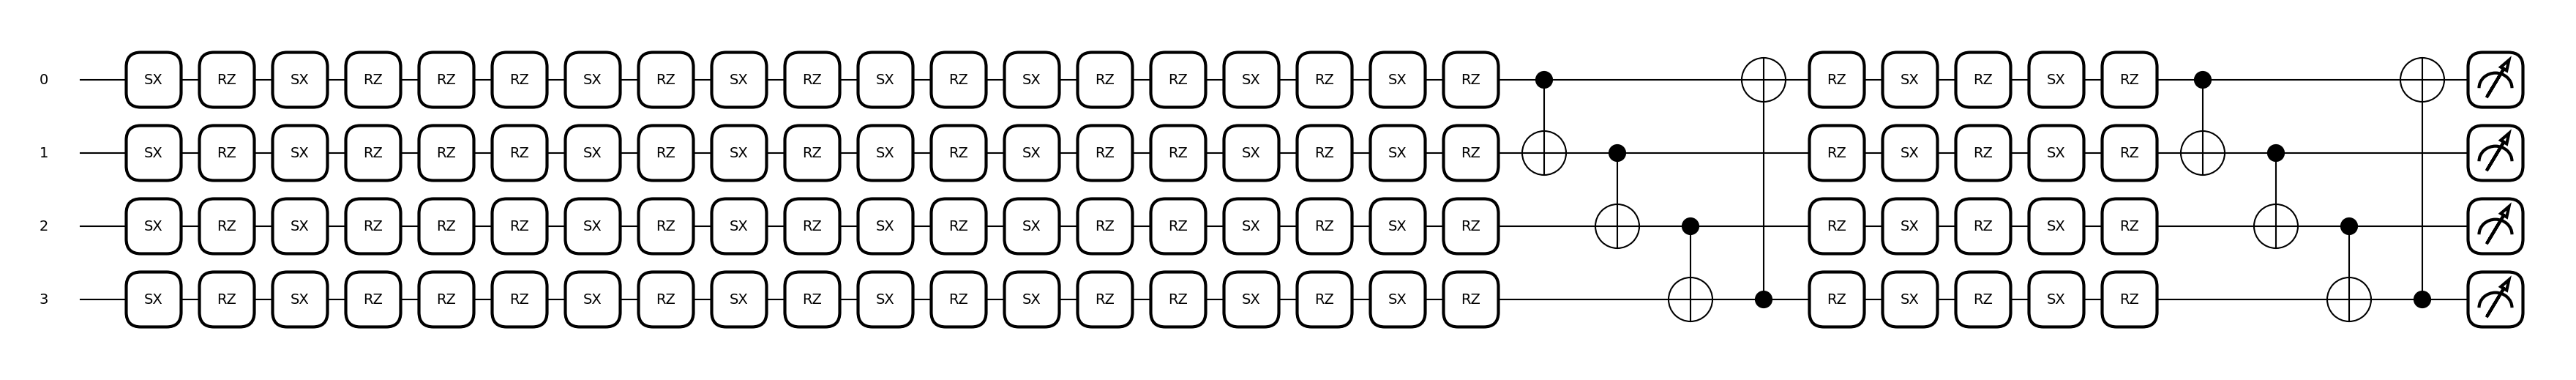

In [8]:
m=4
n=4

dev = qml.device("qiskit.aer",wires=m,backend="aer_simulator_statevector")

# @qml.qnode(dev)
def layer(inputs,weights):
      for i in range(m):
        qml.RY(inputs[n*i],wires=i)
        qml.RZ(inputs[n*i+1],wires=i)
        qml.RX(inputs[n*i+2],wires=i)
        qml.RY(inputs[n*i+3],wires=i)
      qml.BasicEntanglerLayers(weights[0:2],wires=range(m))

      return [qml.expval(qml.PauliZ(i)) for i in range(m)]


weight_shape = qml.BasicEntanglerLayers.shape(n_layers=2, n_wires=m)
weights = np.random.random(weight_shape)
input=np.random.random((m*n))
print(qml.draw_mpl(qml.QNode(layer,dev),expansion_strategy="device")(input,weights))

def custom_ry(theta,wires):
    return [
        qml.SX(wires=wires),
        qml.RZ(theta+np.pi,wires=wires),
        qml.SX(wires=wires),
        qml.RZ(3*np.pi,wires=wires)
    ]
def custom_rx(theta,wires):
    return [
        qml.RZ(np.pi/2,wires=wires),
        qml.SX(wires=wires),
        qml.RZ(theta+np.pi,wires=wires),
        qml.SX(wires=wires),
        qml.RZ(5*np.pi/2,wires=wires),
    ]
custom_decomps = {qml.RY: custom_ry,qml.RX:custom_rx}

decomp_dev = qml.device("qiskit.aer",wires=m,backend="aer_simulator_statevector", custom_decomps=custom_decomps)

from pennylane.transforms import commute_controlled, cancel_inverses
pipeline = [commute_controlled, cancel_inverses]

# @partial(qml.compile, pipeline=pipeline)

decomp_qnode = qml.QNode(layer, decomp_dev)

print(qml.draw_mpl(decomp_qnode,expansion_strategy="device")(input,weights))


Processing given data through the circuit

In [ ]:
m=2
dev = qml.device("default.qubit",wires=m)
from numpy import ceil
@qml.qnode(dev)
def circuit(phi):
  for i in range(len(phi)//2):
    f1=np.cos(phi[2*i])
    f2=np.sin(phi[2*i])
    g=np.exp(1j*phi[2*i+1])
    u=np.array([[f1,-g*f2],[g*f2,f1]])

    qml.QubitUnitary(u,wires=i)
  return [qml.expval(qml.PauliZ(j)) for j in range(m)]

In [ ]:
# super dense angle encoding
m=2
dev = qml.device("default.qubit",wires=m)
from numpy import ceil
theta=0.5
phi=0.5
@qml.qnode(dev)
def circuit(features):
  # qml.e(phi,wires=range(m),rotation='X')
  for i in range(len(features)//2):
    a=features[2*i]
    b=features[2*i+1]
    aa=theta*a+phi*b
    u=np.array([[np.cos(aa),-np.sin(aa)],
                [np.sin(aa),np.cos(aa)]])

    qml.QubitUnitary(u,wires=i)
  return [qml.expval(qml.PauliZ(j)) for j in range(m)]

In [ ]:
def r1(X_train):
  l=len(X_train)
  q_train=[]
  for i,x in enumerate(X_train):
    print(i,"/",l)
    q_img=np.zeros((14,14,2))
    img=x
    for j in range(0,28,2):
      for k in range(0,28,2):
        qres=circuit([img[j,k,0],img[j+1,k+1,0],img[j+1,k,0],img[j,k+1,0]])
        for c in range(m):
          q_img[j//2,k//2,c]=qres[c]
    q_train.append(q_img)
  return q_train
q_train=r1(X_train)
print(len(q_train))

In [ ]:
import matplotlib.pyplot as plt
print(len(q_train))
channel=2
fig,axes=plt.subplots(1+channel,1,figsize=(10,10))
i=0
axes[0].set_ylabel("Input")
axes[0].imshow(X_train[i][:,:,0],cmap="gray")
for c in range(channel):
  axes[c+1].set_ylabel("Output[ch. {}]".format(c))
  axes[c+1].imshow(q_train[i][:,:,c],cmap="gray")

plt.tight_layout()
plt.show()

Fidelity calculation

In [ ]:
def circ1():
  #circuit
  return qml.state()

def circ2():
  #circuit
  return qml.state()

state1=circ1()
state2=circ2()

Fidelity=np.sqrt(abs(state1.dot(state2.conj().T)))

In [ ]:
def dephasing_kraus_map(p=.1):
  return [np.sqrt(1-p)*np.eye(2), np.sqrt(p)*np.diag([1, -1])]

def append_kraus_to_gate(kraus_ops, g):
  return [kj.dot(g) for kj in kraus_ops]

def damping_kraus_map(p= 0.10):
    damping_op = np.sqrt(p) * np.array([[0, 1], [0, 0]])

    residual_kraus = np.diag([1, np.sqrt(1 - p)])
    return [residual_kraus, damping_op]

def pauli_kraus_map(probabilities):
    if len(probabilities) not in [4, 16]:
        raise ValueError(
            "Currently we only support one or two qubits, "
            "so the provided list of probabilities must have length 4 or 16."
        )
    if not np.allclose(sum(probabilities), 1.0, atol=1e-3):
        raise ValueError("Probabilities must sum to one.")

    paulis = [
        np.eye(2),
        np.array([[0, 1], [1, 0]]),
        np.array([[0, -1j], [1j, 0]]),
        np.array([[1, 0], [0, -1]]),
    ]

    if len(probabilities) == 4:
        operators = paulis
    else:
        operators = np.kron(paulis, paulis)

    return [coeff * op for coeff, op in zip(np.sqrt(probabilities), operators)]

def dephased_rx_gate(phi, p=.1):
    corrupted_rx = append_kraus_to_gate(dephasing_kraus_map(p),
    np.array([[np.cos(phi / 2), -1j * np.sin(phi / 2)], [-1j * np.sin(phi / 2), np.cos(phi / 2)]]))
    return corrupted_rx

def dephased_rz_gate(phi, p=.1):
    corrupted_rz = append_kraus_to_gate(dephasing_kraus_map(p),
    np.array([[np.cos(phi / 2) - 1j * np.sin(phi / 2), 0], [0, np.cos(phi / 2) + 1j * np.sin(phi / 2)]]))
    return corrupted_rz

def dephased_ry_gate(phi, p=.1):
    corrupted_ry = append_kraus_to_gate(dephasing_kraus_map(p),
    np.array([[np.cos(phi / 2), -np.sin(phi / 2)], [np.sin(phi / 2), np.cos(phi / 2)]]))
    return corrupted_ry

def dephased_i_gate(p=.1):
    corrupted_iden = append_kraus_to_gate(dephasing_kraus_map(p),
    np.array([[1, 0], [0, 1]]))
    return corrupted_iden

def pauli_noise_i_gate(p_I=.7, p_x=0.1, p_y=0.1, p_z=0.1):
    corrupted_iden = append_kraus_to_gate(pauli_kraus_map([p_I, p_x, p_y, p_z]),
    np.array([[1, 0], [0, 1]]))
    return corrupted_iden

def pauli_noise_z_gate(p_I=.7, p_x=0.1, p_y=0.1, p_z=0.1):
    corrupted_Z = append_kraus_to_gate(pauli_kraus_map([p_I, p_x, p_y, p_z]),
    np.array([[1, 0], [0, -1]]))
    return corrupted_Z

def bitflip(p=.1):
    return pauli_noise_i_gate(1-p,p,0,0)

def phaseflip(p=.1):
    return pauli_noise_i_gate(1-p,0,0,p)

def depolarizing(p=0.3):
    p=1-p
    return pauli_noise_i_gate(p,p/3,p/3,p/3)

def amp_damp_i_gate(p=.1):
    corrupted_i = append_kraus_to_gate(damping_kraus_map(p), np.array([[1, 0], [0, 1]]))
    return corrupted_i